## Tutorial 2: Mixture Models: Mixture of Gaussians: Solutions

In this tutorial, we will learn how to build and train our first generative model.

### 🔧 Setup and imports




In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt

## Implement a mixture of Gaussian distribution

- Consider three normal distributions with distinct components $(μ, σ, w)$
- Plot the normal distributions and compute the mixture of the distribution

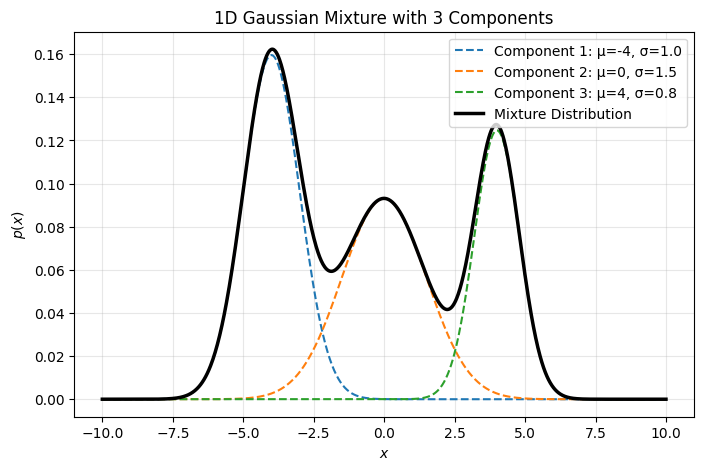

In [ ]:
# ✅ Plot 1D Gaussian Mixture (multiple components)

import numpy as np
import matplotlib.pyplot as plt

# Define x-axis
x = np.linspace(-10, 10, 1000)

# Define mixture parameters
weights = np.array([0.4, 0.35, 0.25])  # sum to 1
mus = np.array([-4, 0, 4])
sigmas = np.array([1.0, 1.5, 0.8])

# Compute individual component densities
components = [
    w * (1 / (np.sqrt(2 * np.pi) * s)) * np.exp(-0.5 * ((x - m) / s) ** 2)
    for w, m, s in zip(weights, mus, sigmas)
]

# Combined mixture
mixture = np.sum(components, axis=0)

# Plot
plt.figure(figsize=(8, 5))
for i, c in enumerate(components):
    plt.plot(x, c, '--', label=f'Component {i+1}: μ={mus[i]}, σ={sigmas[i]}')

plt.plot(x, mixture, color='k', linewidth=2.5, label='Mixture Distribution')
plt.title("1D Gaussian Mixture with 3 Components")
plt.xlabel("$x$")
plt.ylabel("$p(x)$")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## Dataset: Digits

### 📦 Dataset wrapper: `Digits`

The goal of this cell is to wrap the **scikit‑learn Digits dataset** into a small PyTorch `Dataset` class so that we can later feed it to a `DataLoader`.

**What the class does:**
1. Loads the digits data from `sklearn`.
2. Splits it into **train / validation / test** subsets.
3. Optionally applies a transform (normalisation, noise, …).
4. Returns items as **floating point tensors** of shape $(64,)$ — because each digit image is $8 \times 8 = 64$ pixels.

Mathematically, each observation is
$$
\mathbf{x}^{(i)} \in \mathbb{R}^{64}, \quad i = 1, \dots, N.
$$

We will later model the distribution of these $\mathbf{x}$’s with a mixture of Gaussians.


In [ ]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
        else:
            self.data = digits.data[1350:].astype(np.float32)

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample

---
💡 **Task: TO-DO**


1. Instantiate the training split of the `Digits` dataset.  
2. Print the **shape** of the first item and **min/max** values.  
3. Visualise the first 4 digits as $8\times 8$ images.




Shape of one sample: (64,)
Min / Max: 0.0 15.0
(64,)


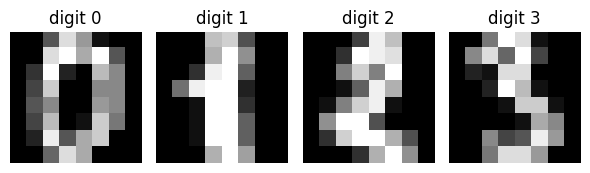

In [ ]:
import matplotlib.pyplot as plt

ds = Digits(mode='train')
x0 = ds[0]
print("Shape of one sample:", x0.shape)
print("Min / Max:", x0.min(), x0.max())
print(x0.shape)
fig, axes = plt.subplots(1, 4, figsize=(6, 2))
for i in range(4):
    img = ds[i].reshape(8, 8)
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(f"digit {i}")
    axes[i].axis("off")
plt.tight_layout()

## Mixture Models


### 🧠 Defining the Mixture of Gaussians model (`MoG`)

This cell defines our **probabilistic model**:
$$
p(\mathbf{x}) = \sum_{k=1}^K \pi_k \, \mathcal{N}(\mathbf{x} \mid \boldsymbol\mu_k, \operatorname{diag}(\boldsymbol\sigma_k^2)),
$$
where

- $K$ is the **number of mixture components**,
- $\pi_k$ are the **mixing coefficients** (non‑negative and $\sum_k \pi_k = 1$),
- $\boldsymbol\mu_k \in \mathbb{R}^D$ are the **means**,
- $\boldsymbol\sigma_k^2 \in \mathbb{R}^D$ are the **(diagonal) variances**.

In code we parameterise:
- the means as a learnable tensor `mu` of shape `(1, K, D)`,
- the (log) variances as `log_var` so that variances stay positive,
- the mixture weights as unnormalised logits `w`, which we later turn into a probability simplex using **softmax**.

This class will also contain helper methods such as:
- `log_prob(x, reduction=...)` → to compute $\log p(\mathbf{x})$,
- possibly `sample(...)` → to generate digits from the learned mixture.




In [ ]:
class MoG(nn.Module):
    def __init__(self, D, K, uniform=False):
        super(MoG, self).__init__()

        # hyperparams
        self.uniform = uniform
        self.D = D  # the dimensionality of the input
        self.K = K  # the number of components

        # params
        self.mu = nn.Parameter(torch.randn(1, self.K, self.D) * 0.25 + 0.5)
        self.log_var = nn.Parameter(-3. * torch.ones(1, self.K, self.D))

        if self.uniform:
            self.w = torch.zeros(1, self.K)
            self.w.requires_grad = False
        else:
            self.w = nn.Parameter(torch.zeros(1, self.K))

        # other
        self.PI = torch.from_numpy(np.asarray(np.pi))

    def log_diag_normal(self, x, mu, log_var, reduction='sum', dim=1):
        log_p = -0.5 * torch.log(2. * self.PI) - 0.5 * log_var - 0.5 * torch.exp(-log_var) * (x.unsqueeze(1) - mu)**2.
        return log_p

    def forward(self, x, reduction='mean'):
        # calculate components
        log_pi = torch.log(F.softmax(self.w, 1))  # B x K, softmax is used for R^K -> [0,1]^K s.t. sum(pi) = 1
        log_N = torch.sum(self.log_diag_normal(x, self.mu, self.log_var), 2)  # B x K, log-diag-Normal for K components

        # =====LOSS: Negative Log-Likelihood
        NLL_loss = -torch.logsumexp(log_pi + log_N,  1)  # B

        # Final LOSS
        if reduction == 'sum':
            return NLL_loss.sum()
        elif reduction == 'mean':
            return NLL_loss.mean()
        else:
            raise ValueError('Either `sum` or `mean`.')

    def sample(self, batch_size=64):
        # init an empty tensor
        x_sample = torch.empty(batch_size, self.D)

        # sample components
        pi = F.softmax(self.w, 1)  # B x K, softmax is used for R^K -> [0,1]^K s.t. sum(pi) = 1

        indices = torch.multinomial(pi, batch_size, replacement=True).squeeze()

        for n in range(batch_size):
            indx = indices[n]  # pick the n-th component
            x_sample[n] = self.mu[0,indx] + torch.exp(0.5*self.log_var[0,indx]) * torch.randn(self.D)

        return x_sample

    def log_prob(self, x, reduction='mean'):
        with torch.no_grad():
            # calculate components
            log_pi = torch.log(F.softmax(self.w, 1))  # B x K, softmax is used for R^K -> [0,1]^K s.t. sum(pi) = 1
            log_N = torch.sum(self.log_diag_normal(x, self.mu, self.log_var), 2)  # B x K, log-diag-Normal for K components

            # log_prob
            log_prob = torch.logsumexp(log_pi + log_N,  1)  # B

            if reduction == 'sum':
                return log_prob.sum()
            elif reduction == 'mean':
                return log_prob.mean()
            else:
                raise ValueError('Either `sum` or `mean`.')

---
💡 **TO-DO — understanding the MoG forward pass**

**Task:**  
1. Create a dummy batch `x` of size `(5, 64)` sampled from `torch.randn`.  
2. Pass it through `model.log_prob(x)` to get the log-likelihood.  
3. Check that the output has shape `(5,)` or a single scalar depending on `reduction`.  
4. Change the number of components `K` and observe how the parameters change.




In [ ]:
tmp_model = MoG(D=64, K=3, uniform=True)
x = torch.randn(5, 64)
logp = tmp_model.log_prob(x, reduction='sum')
print("log p(x) shape:", logp.shape)
print("mixture means shape:", tmp_model.mu.shape)
print("mixture log-var shape:", tmp_model.log_var.shape)
print("mixture logits shape:", tmp_model.w.shape)

log p(x) shape: torch.Size([])
mixture means shape: torch.Size([1, 3, 64])
mixture log-var shape: torch.Size([1, 3, 64])
mixture logits shape: torch.Size([1, 3])


## 🧪 Evaluation, sampling, and visualisation

This cell defines an **evaluation routine** that we will call **after or during training**.

What it does:
1. **Loads** the best model from disk (the one with the lowest validation loss).
2. **Switches to evaluation mode** (`model.eval()`).
3. Loops over the **test set** and computes the **average negative log‑likelihood (NLL)**:
   $$
   \text{NLL} = - \frac{1}{N} \sum_{i=1}^N \log p_\theta(\mathbf{x}^{(i)}),
   $$
   which is the standard metric for generative models.
4. Optionally **produces plots / samples / curve of losses** to inspect whether the mixture learned interpretable components.
5. It also has small helpers to **visualise the means** as $8 \times 8$ images with their associated mixture weights.



In [ ]:
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + '.model', weights_only= False)

    model_best.eval()
    loss = 0.
    N = 0.
    for indx_batch, test_batch in enumerate(test_loader):
        loss_t = -model_best.log_prob(test_batch, reduction='sum')
        loss = loss + loss_t.item()
        N = N + test_batch.shape[0]
    loss = loss / N

    if epoch is None:
        print(f'FINAL LOSS: nll={loss}')
    else:
        print(f'Epoch: {epoch}, val nll={loss}')

    return loss


def samples_real(name, test_loader):
    # REAL-------
    num_x = 4
    num_y = 4
    x = next(iter(test_loader)).detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
    plt.close()


def samples_generated(name, data_loader, extra_name=''):
    with torch.no_grad():
        # GENERATIONS-------
        model_best = torch.load(name + '.model', weights_only=False)

        num_x = 4
        num_y = 4
        x = model_best.sample(batch_size=num_x * num_y)
        x = x.detach().numpy()

        fig, ax = plt.subplots(num_x, num_y)
        for i, ax in enumerate(ax.flatten()):
            plottable_image = np.reshape(x[i], (8, 8))
            ax.imshow(plottable_image, cmap='gray')
            ax.axis('off')

        plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
        plt.close()

def plot_curve(name, nll_val):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel('epochs')
    plt.ylabel('nll')
    plt.savefig(name + '_nll_val_curve.pdf', bbox_inches='tight')
    plt.close()

def means_save(name, extra_name='', num_x = 4, num_y = 4):
    with torch.no_grad():
        # GENERATIONS-------
        model_best = torch.load(name + '.model', weights_only=False)

        pi = F.softmax(model_best.w, 1).squeeze()

        x = model_best.mu[:, 0:num_x * num_y]
        N = x.shape[1]
        x = x.squeeze(0).detach().numpy()

        fig, ax = plt.subplots(int(np.sqrt(N)), int(np.sqrt(N)))
        for i, ax in enumerate(ax.flatten()):
            plottable_image = np.reshape(x[i], (8, 8))
            ax.imshow(plottable_image, cmap='gray')
            ax.set_title(f'$\pi$ = {pi[i].item():.5f}')
            ax.axis('off')
        fig.tight_layout()
        plt.savefig(name + '_means_images' + extra_name + '.pdf', bbox_inches='tight')
        plt.close()

<>:81: SyntaxWarning: invalid escape sequence '\p'
<>:81: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-526229619.py:81: SyntaxWarning: invalid escape sequence '\p'
  ax.set_title(f'$\pi$ = {pi[i].item():.5f}')


---
💡 **TO-DO — computing NLL on a subset**

Sometimes you don’t want to run evaluation on the *whole* test set.

**Task:**  
1. Take only the **first batch** from `test_loader`.  
2. Load the best model from disk.  
3. Compute the NLL on that batch only.  
4. Compare it to the full-test NLL you get from `evaluation(...)`.




In [ ]:
# assuming `test_loader` and a saved model exist
best_model = torch.load(result_dir + name + '.model')
best_model.eval()

test_iter = iter(test_loader)
batch = next(test_iter)
with torch.no_grad():
    loss_t = -best_model.log_prob(batch, reduction='sum')
    n = batch.shape[0]
    nll_batch = (loss_t / n).item()

print("NLL on first batch:", nll_batch)

### 🚂 Training loop for the GMM

This cell defines the **training procedure**. Even though classical GMMs are often trained with **EM**, here we show that we can **directly optimise the log‑likelihood with gradient descent**.

**Objective:** maximise
$$
\mathcal{L}(\theta) = \sum_{i=1}^N \log \Bigg( \sum_{k=1}^K \pi_k \, \mathcal{N}(\mathbf{x}^{(i)} \mid \boldsymbol\mu_k, \operatorname{diag}(\boldsymbol\sigma_k^2)) \Bigg),
$$
or, equivalently, **minimise** the negative of this value (NLL).

**What the function does:**
1. Loops over epochs.
2. For every mini‑batch, calls the model to get the **NLL**, backpropagates, and does an **optimizer step**.
3. After each epoch, evaluates on the **validation set** to implement **early stopping**.
4. Saves the **best‑performing model** to disk.
5. Optionally generates samples to monitor training.



In [ ]:
def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader):
    nll_val = []
    best_nll = 1000.
    patience = 0

    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train()
        for indx_batch, batch in enumerate(training_loader):
            loss = model(batch)

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        # Validation
        loss_val = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_val)  # save for plotting

        if e == 0:
            print('saved!')
            torch.save(model, name + '.model')
            best_nll = loss_val
        else:
            if loss_val < best_nll:
                print('saved!')
                torch.save(model, name + '.model')
                best_nll = loss_val
                patience = 0
            else:
                patience = patience + 1

        samples_generated(name, val_loader, extra_name="_epoch_" + str(e))

        if patience > max_patience:
            break

    nll_val = np.asarray(nll_val)

    return nll_val

## Experiments

**Initialize datasets**

### 🧼 Data transform

Before feeding images to the model, we apply a small **pre‑processing transform**:

- rescale the raw digits (0–16) to roughly **[-1, 1]**,
- optionally add a **small Gaussian noise** to make the density estimation less degenerate.

This corresponds to the common practice of slightly **de‑quantising** discrete images when using continuous density models.


In [ ]:
transforms = tt.Lambda(lambda x: (x/17.) + (np.random.randn(*x.shape)/136.))  # changing to [-1, 1] and adding small Gaussian noise

---
💡 **TO-DO — effect of de-quantisation**

Our transform adds a *small* Gaussian noise.

**Task:**  
1. Remove the noise term from the transform.  
2. Recreate the dataset and visualise again.  
3. Discuss: why might a continuous density model prefer slightly noisy inputs?



Min/max without noise: 0.0 0.88235295
Min/max with noise: -0.019074867448809946 0.886261995223194
(64,)


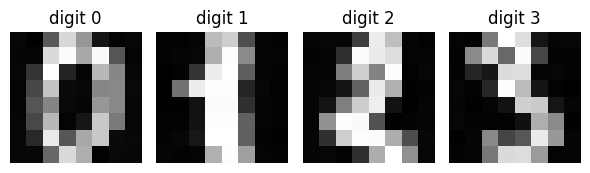

In [ ]:
# transform without noise
transforms_no_noise = tt.Lambda(lambda x: (x/17.))
train_data_no_noise = Digits(mode='train', transforms=transforms_no_noise)

x0 = train_data_no_noise[0]
print("Min/max without noise:", x0.min(), x0.max())

train_data = Digits(mode = 'train', transforms=transforms)
x1 = train_data[0]
print("Min/max with noise:", x1.min(), x1.max())

print(x1.shape)
fig, axes = plt.subplots(1, 4, figsize=(6, 2))
for i in range(4):
    img = train_data[i].reshape(8, 8)
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(f"digit {i}")
    axes[i].axis("off")
plt.tight_layout()

### 📥 Building the data loaders

Here we actually **instantiate** the `Digits` dataset three times:
- **training set** (used to update the parameters),
- **validation set** (used for early stopping),
- **test set** (used only at the very end).

Then we wrap them into **PyTorch `DataLoader`s** to get batches.



In [ ]:
train_data = Digits(mode='train', transforms=transforms)
val_data = Digits(mode='val', transforms=transforms)
test_data = Digits(mode='test', transforms=transforms)

training_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

**Hyperparameters**

### ⚙️ Hyperparameters for the Mixture of Gaussians

This cell lists the **key hyperparameters**:

- $D = 64$ → dimensionality of the digits,
- $K = 25$ → number of mixture components (i.e. how many Gaussians we allow),
- learning rate, number of epochs, and early‑stopping patience.

**Rule of thumb:** larger $K$ ⇒ more expressive model but also harder optimisation and risk of overfitting.


In [ ]:
D = 64   # input dimension

K = 25  # the number of neurons in scale (s) and translation (t) nets

lr = 1e-3 # learning rate
num_epochs = 200 # max. number of epochs
max_patience = 20 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

**Creating a folder for results**

### 🗂️ Creating a results directory

We keep all artefacts of a run (model checkpoints, generated samples, learning curves) inside a folder:

- name is constructed from the model type and $K$,
- folder is created if it doesn’t exist.

This makes runs reproducible and easy to inspect.


In [ ]:

name = 'mog' + '_' + str(K)
if not (os.path.exists('results/')):
    os.mkdir('results/')
result_dir = 'results/' + name + '/'
if not (os.path.exists(result_dir)):
    os.mkdir(result_dir)

**Initializing the model**

### 🏗️ Model instantiation

Here we actually **create** the Mixture of Gaussians model with the chosen dimensionality `D` and number of components `K`:

```python
model = MoG(D=D, K=K, uniform=True)
```

The flag `uniform=True` initialises the mixture weights so that all components start with
$$
\pi_k = \frac{1}{K},
$$
which is a sensible default for teaching.


In [ ]:
# Eventually, we initialize the full model
model = MoG(D=D, K=K, uniform=True)

### 🛠️ Choosing an optimizer

We use **AdamW** here, which is a modern variant of Adam with decoupled weight decay.  
Why? Because our parameters are continuous and can vary in scale (means vs. log‑variances vs. logits). Adaptive optimizers usually handle this better than vanilla SGD.

If you want to **experiment**, try:
- SGD with momentum,
- different learning rates,
- freezing some parameters.


In [ ]:
# OPTIMIZER
torch.optim.Adam([p for p in model.parameters() if p.requires_grad == True], lr=lr)
# optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad == True], lr=lr, momentum=0.1, weight_decay=1.e-4)
optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad == True], lr=lr)

---
💡 **TO-DO — different optimizers**

**Task:**  
1. Replace AdamW with SGD + momentum.  
2. Train for 10–20 epochs.  
3. Compare the validation NLL curves.




In [ ]:
opt_sgd = torch.optim.SGD([p for p in model.parameters() if p.requires_grad],
                          lr=1e-2, momentum=0.9)
nll_sgd = training(name=result_dir + name + "_sgd",
                   max_patience=5,
                   num_epochs=50,
                   model=model,
                   optimizer=opt_sgd,
                   training_loader=training_loader,
                   val_loader=val_loader)

**Training loop**

### ▶️ Actual training

This cell **launches** the training procedure defined earlier:

1. calls `training(...)` with the model, optimizer and data loaders,
2. stores the validation NLL values,
3. lets early stopping stop the run if validation does not improve.

After this cell finishes, you should have a **trained GMM** saved on disk.


In [ ]:
# Training procedure
nll_val = training(name=result_dir + name, max_patience=max_patience, num_epochs=num_epochs, model=model, optimizer=optimizer,
                       training_loader=training_loader, val_loader=val_loader)

Epoch: 0, val nll=69.15919937568401
saved!
Epoch: 1, val nll=58.95765920632806
saved!
Epoch: 2, val nll=50.33907289977461
saved!
Epoch: 3, val nll=43.174573166069244
saved!
Epoch: 4, val nll=37.17071280933743
saved!
Epoch: 5, val nll=32.251866353291526
saved!
Epoch: 6, val nll=28.011368014004923
saved!
Epoch: 7, val nll=24.364567018113853
saved!
Epoch: 8, val nll=21.31423746081709
saved!
Epoch: 9, val nll=18.604345880899228
saved!
Epoch: 10, val nll=16.252152997885904
saved!
Epoch: 11, val nll=14.213948641880766
saved!
Epoch: 12, val nll=12.375148232511002
saved!
Epoch: 13, val nll=10.740802292270521
saved!
Epoch: 14, val nll=9.341831928108045
saved!
Epoch: 15, val nll=8.025479967021214
saved!
Epoch: 16, val nll=6.859674442019346
saved!
Epoch: 17, val nll=5.7690606507201965
saved!
Epoch: 18, val nll=4.8427233910501934
saved!
Epoch: 19, val nll=4.035331061265635
saved!
Epoch: 20, val nll=3.2621017116967455
saved!
Epoch: 21, val nll=2.511104323287066
saved!
Epoch: 22, val nll=1.858430733

---
💡 **Try it yourself — inspect learned components**

**Task:**  
1. After training, load the best model.  
2. Extract `mu` and visualise the first 16 means as $8\times 8$ images.  
3. Next to each, print the corresponding $\pi_k$.



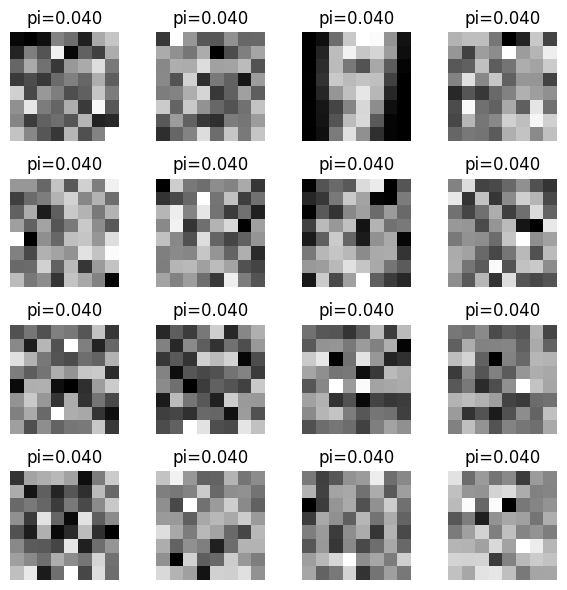

In [ ]:
best_model = torch.load(result_dir + name + '.model', weights_only=False)
best_model.eval()

with torch.no_grad():
    pi = torch.softmax(best_model.w, dim=1).squeeze(0)  # (K,)
    mus = best_model.mu.squeeze(0)  # (K, D)

import matplotlib.pyplot as plt
n_show = min(16, mus.shape[0])
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i in range(n_show):
    ax = axes[i//4, i%4]
    ax.imshow(mus[i].detach().cpu().reshape(8, 8), cmap="gray")
    ax.set_title(f"pi={pi[i].item():.3f}")
    ax.axis("off")
plt.tight_layout()

**Expected output / notes:**  
- Students should see “prototype digits”.  
- Some components might look similar → chance to talk about **component redundancy**.

**The final evaluation**

### ✅ Final evaluation and qualitative inspection

To conclude, we:
1. run the evaluation on the **test set**,
2. **save** the test NLL,
3. **visualise** real vs. generated samples,
4. **plot** the training curve,
5. **visualise** the learned component means (as $8\times 8$ images) together with their learned mixture weights.

This helps students connect the **abstract parameters** $(\pi_k, \boldsymbol\mu_k, \boldsymbol\sigma_k)$ with actual **digit prototypes**.


In [ ]:
test_loss = evaluation(name=result_dir + name, test_loader=test_loader)
f = open(result_dir + name + '_test_loss.txt', "w")
f.write(str(test_loss))
f.close()

samples_real(result_dir + name, test_loader)
samples_generated(result_dir + name, test_loader, extra_name='FINAL')

means_save(result_dir + name, extra_name='_'+str(K), num_x=5, num_y=5)

plot_curve(result_dir + name, nll_val)

FINAL LOSS: nll=13.166848760486983


---
💡 **Try it yourself — compare real vs. generated**

**Task:**  
1. Sample 25 real digits from the test set.  
2. Sample 25 digits from the model.  
3. Plot them side by side.  
4. Ask: *does the model cover the support of the data?*


In [ ]:

# Real samples
samples_real(result_dir + name, test_loader)

# Generated samples
samples_generated(result_dir + name, test_loader, extra_name="COMPARE")

---
💡 **TO-DO — Model Generalizability**

**Task:**  
1. Change `K` to a **very small** value (e.g. 3) or to a **larger** value (e.g. 50)
2. Train briefly in both cases (few epochs).  
3. Compare the validation NLLs.




In [ ]:
## TODO
for k in [3, 20, 50]:
  model = MoG(D=D, K=k, uniform=True)
  opt_sgd = torch.optim.SGD([p for p in model.parameters() if p.requires_grad],
                          lr=1e-2, momentum=0.9)
  nll_sgd = training(name=result_dir + name + "_sgd",
                   max_patience=5,
                   num_epochs=10,
                   model=model,
                   optimizer=opt_sgd,
                   training_loader=training_loader,
                   val_loader=val_loader)

Epoch: 0, val nll=-1.3408863988619821
saved!
Epoch: 1, val nll=-10.979399137676225
saved!
Epoch: 2, val nll=-17.89153879899326
saved!
Epoch: 3, val nll=-12.379625001755839
Epoch: 4, val nll=56.0670916657055
Epoch: 5, val nll=6.7088275963944675
Epoch: 6, val nll=-8.1694032276936
Epoch: 7, val nll=20.812877858036803
Epoch: 8, val nll=71.16469680326531
Epoch: 0, val nll=-1.2016696261674231
saved!
Epoch: 1, val nll=-7.278825234933781
saved!
Epoch: 2, val nll=-13.080046837083204
saved!
Epoch: 3, val nll=-18.55092787439951
saved!
Epoch: 4, val nll=-22.499322606587917
saved!
Epoch: 5, val nll=-17.564052137626994
Epoch: 6, val nll=-15.69414080244238
Epoch: 7, val nll=4.85887699860567
Epoch: 8, val nll=-10.542077486759807
Epoch: 9, val nll=36.867478204569586
Epoch: 0, val nll=-1.8057710379053082
saved!
Epoch: 1, val nll=-12.552762201840615
saved!
Epoch: 2, val nll=5.035899119244113
Epoch: 3, val nll=-8.519472719183549
Epoch: 4, val nll=48.463782761758225
Epoch: 5, val nll=-2.807884185531376
Epo

### 🚨 Detecting Out-of-Distribution (OOD) Samples

One useful property of generative models like GMMs is that they assign a **likelihood score** to every input.
By comparing these likelihoods, we can identify *unusual* or *out-of-distribution* (OOD) data points.

#### Idea:
- Compute $\log p_\theta(x)$ for real test samples (Digits).
- Compute $\log p_\theta(x)$ for fake / random samples.
- Compare the two distributions.

If our model is well-trained, OOD samples should have **significantly lower likelihoods**.


In [ ]:
## TODO
data = iter(training_loader)
train_data_batch = next(data)
single_sample = train_data_batch[0]
print(single_sample.shape)
log_prob_single_sample = model.log_prob(single_sample.unsqueeze(0))
print(log_prob_single_sample)

rand = torch.rand(1, 64)
log_prob_rand = model.log_prob(rand)
print(log_prob_rand)

torch.Size([64])
tensor(-10.5639, dtype=torch.float64)
tensor(-38.9708)
